In [36]:
%%bash
pip install lightfm

In [0]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn import model_selection
from sklearn.model_selection import KFold
from scipy.sparse import coo_matrix
from time import time
import matplotlib.pyplot as plt
import csv

import numpy as np
import pandas as pd

from google.colab import files

## Util

In [0]:
def downloadCSVFile(listOfDicts, fileName):
  resultDF = pd.DataFrame(listOfDicts)
  resultDF.to_csv(fileName)
#   files.download(fileName)

##Get Data

In [0]:
# %%bash
# mkdir -p 'results'

# rm ratings.csv

In [0]:
# Upload ratings.csv

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ratings_1387672.csv to ratings_1387672.csv


### Make Train, Validate, Test

In [42]:
# ratingsDataPath = 'data-medium/ratings_8326033.csv'
ratingsDataPath = 'ratings.csv'

ratingsDF = pd.read_csv(ratingsDataPath)
ratingsDF = ratingsDF[['userId', 'movieId', 'rating']]

# Alter ratings to work better for our model
ratingsDF['rating'] = ratingsDF['rating'].apply(lambda x: x - 2.9)

ratingsDF['userId'] = ratingsDF['userId'].astype('int32')
ratingsDF['movieId'] = ratingsDF['movieId'].astype('int32')

userIds = ratingsDF['userId'].unique()
movieIds = ratingsDF['movieId'].unique()

movieIdToIndex = {}
for index, movieId in enumerate(movieIds):
  movieIdToIndex[movieId] = index

userIdToIndex = {}
for index, userId in enumerate(userIds):
  userIdToIndex[userId] = index

ratingsTrainDF, ratingsTestDF = model_selection.train_test_split(ratingsDF, test_size=0.2, random_state=324)

# We want to do k-fold validation, so we create k differen't versions of the data
ratingsTrainArray = ratingsTrainDF.values

k = 3
trainValidateArrays = []
kFold = KFold(n_splits=k, random_state=299, shuffle=True)
for train_index, test_index in kFold.split(ratingsTrainArray):
  ratingsTrainGridSearch, ratingsValidateGridSearch = ratingsTrainArray[train_index], ratingsTrainArray[test_index]
  trainValidateArrays.append((ratingsTrainGridSearch, ratingsValidateGridSearch))
# ratingsTrainGridSearchDF, ratingsValidateGridSearchDF = model_selection.train_test_split(ratingsTrainDF, test_size=0.2, random_state=773)

print('We have {} users'.format(len(userIds)))
print('We have {} movies'.format(len(movieIds)))
print('We have {} train ratings'.format(len(ratingsTrainDF)))
print('We have {} test ratings'.format(len(ratingsTestDF)))
print('We have {} grid search train ratings for each of {} folds'.format(len(trainValidateArrays[0][0]), k))
print('We have {} grid search validate ratings for each of {} folds'.format(len(trainValidateArrays[0][1]), k))

We have 610 users
We have 9724 movies
We have 80668 train ratings
We have 20168 test ratings
We have 53778 grid search train ratings for each of 3 folds
We have 26890 grid search validate ratings for each of 3 folds


In [43]:
ratingsTrainDF.head()

,userId,movieId,rating
24133,167,2231,1.6
71266,456,104,0.1
88652,572,2670,2.1
65218,418,1206,1.6
77276,483,367,0.1


In [44]:
trainValidateArrays[0][0][1:10]

array([[ 5.72000e+02,  2.67000e+03,  2.10000e+00],
       [ 4.18000e+02,  1.20600e+03,  1.60000e+00],
       [ 4.83000e+02,  3.67000e+02,  1.00000e-01],
       [ 6.01000e+02,  5.95200e+03,  2.10000e+00],
       [ 2.80000e+02,  4.81600e+03,  1.10000e+00],
       [ 1.11000e+02,  1.60271e+05,  2.10000e+00],
       [ 6.08000e+02,  6.19300e+03,  1.60000e+00],
       [ 2.88000e+02,  2.70100e+03, -9.00000e-01],
       [ 1.11000e+02,  6.94360e+04,  1.10000e+00]])

### Convert to Matrix

In [45]:
def ratingsDFToUserMovieMatrix(ratingsDF, userIdToIndex, movieIdToIndex): 
  return ratingsArrayToUserMovieMatrix(ratingsDF.values, userIdToIndex, movieIdToIndex)

def ratingsArrayToUserMovieMatrix(ratings, userIdToIndex, movieIdToIndex):
  numUsers = len(userIdToIndex)
  numMovies = len(movieIdToIndex)
  
  userMovieMatrix = np.zeros((numUsers, numMovies))
  
  for userId, movieId, rating in ratings:
    userId = int(userId)
    movieId = int(movieId)
    rating = float(rating)
    
    userIndex = userIdToIndex[userId]
    movieIndex = movieIdToIndex[movieId]
    userMovieMatrix[userIndex, movieIndex] = rating
    
  
  return coo_matrix(userMovieMatrix)


XTrainValidateFolds = []
for ratingsTrain, ratingsValidate in trainValidateArrays:
  XTrain = ratingsArrayToUserMovieMatrix(ratingsTrain, userIdToIndex, movieIdToIndex)
  XValidate = ratingsArrayToUserMovieMatrix(ratingsValidate, userIdToIndex, movieIdToIndex)
  XTrainValidateFolds.append((XTrain, XValidate))
XTrain = ratingsArrayToUserMovieMatrix(ratingsTrainArray, userIdToIndex, movieIdToIndex)
XTest = ratingsDFToUserMovieMatrix(ratingsTestDF, userIdToIndex, movieIdToIndex)

print('Shape of X Train: {}'.format(XTrain.shape))
print('Shape of X Test: {}'.format(XTest.shape))
print('')
print('Shape of each X Train: {}'.format(XTrainValidateFolds[0][0].shape))
print('Shape of each X Validate: {}'.format(XTrainValidateFolds[0][1].shape))

Shape of X Train: (610, 9724)
Shape of X Test: (610, 9724)

Shape of each X Train: (610, 9724)
Shape of each X Validate: (610, 9724)


# Find Baseline Score

In [0]:
def calculateAUC(userStats):
  tp = userStats['tp']
  fp = userStats['fp']
  tn = userStats['tn']
  fn = userStats['fn']
  if tp + fn == 0 or tn + fp == 0:
    return -5
  tpr = tp / (tp + fn)
  fpr = fp / (tn + fp)
  auc = (tpr - fpr + 1) / 2
  return auc

In [47]:
averageMovieRatings = np.asarray(np.mean(XTrain, axis=0))[0]

numUsers = XTest.shape[0]
numMovies = XTest.shape[1]


startingStats = {
  'tp': 0,
  'fp': 0,
  'tn': 0,
  'fn': 0
}

currentUserIndex = -1
currentUserStats = {**startingStats}
aucPerUser = np.zeros(numUsers)

for userIndex,movieIndex,ratingActual in zip(XTest.row, XTest.col, XTest.data):
  if userIndex != currentUserIndex:
    aucPerUser[currentUserIndex] = calculateAUC(currentUserStats)
    currentUserStats = {**startingStats}
    currentUserIndex = userIndex
  
  if ratingActual != 0:
    ratingPredicted = averageMovieRatings[movieIndex]
    if ratingActual > 0:
      if ratingPredicted > 0:
        currentUserStats['tp'] += 1
      else:
        currentUserStats['fn'] += 1
    else:
      if ratingPredicted > 0:
        currentUserStats['fp'] += 1
      else:
        currentUserStats['tn'] += 1

aucPerUser = [auc for auc in aucPerUser if auc != -5]
baselineAUC = np.mean(aucPerUser)
print('Our baseline AUC is {}'.format(baselineAUC))

Our baseline AUC is 0.5840802952749753


## Add on Side Info from IMDB


### Create Linkage

In [0]:
# grab links file from MovieLens
links_path = 'links.csv'
linksDF = pd.read_csv(links_path)
linksDF = linksDF[['movieId', 'imdbId']]

In [49]:
# make dataframe from movieIds above
just_movie_ids = pd.DataFrame(movieIds)
just_movie_ids.columns = ['movieId']
just_movie_ids.head()

,movieId
0,1
1,3
2,6
3,47
4,50


In [0]:
# merge links to movieIds 
side_info_linkage = just_movie_ids.merge(linksDF, on="movieId", how="left")

In [51]:
side_info_linkage.head()

,movieId,imdbId
0,1,114709
1,3,113228
2,6,113277
3,47,114369
4,50,114814


### Get IMDB Info

In [52]:
 # read in imdb data (filtered to only include movies)
imdb_path = 'title.basics_only_movies.tsv'

imdbDF = pd.read_csv(imdb_path, sep="\t")
imdbDF['tconst'] = imdbDF['tconst'].str[2:].astype(int)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
imdbDF.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,9,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport"
2,335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama"
3,502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
4,574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama"


## Merge

In [54]:
# join to ratings data
# print(with_linksDF.shape)
full_side_info = side_info_linkage.merge(imdbDF, left_on='imdbId', right_on='tconst', how='left')
print(full_side_info.shape)

(9724, 11)


In [55]:
full_side_info = full_side_info[['runtimeMinutes', 'startYear']]

full_side_info['runtimeMinutes'][full_side_info['runtimeMinutes'].isnull()] = 0 # left in till can deal with reading in file
full_side_info['runtimeMinutes'][full_side_info['runtimeMinutes'] == "\\N"] = 0 # one line with no information
full_side_info['runtimeMinutes'] = full_side_info['runtimeMinutes'].astype(int)

full_side_info['startYear'][full_side_info['startYear'].isnull()] = 0 # left in till can deal with reading in file
full_side_info['startYear'] = full_side_info['startYear'].astype(int)

full_side_info.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,runtimeMinutes,startYear
0,81,1995
1,101,1995
2,170,1995
3,127,1995
4,106,1995


### Make Item Feature Matrix

In [58]:
def sideInfoToItemFeatures(side_info, movieIdToIndex):
    return coo_matrix(side_info)   

side_info_matrix = sideInfoToItemFeatures(full_side_info, movieIdToIndex)
print('Shape of Side Info: {}'.format(side_info_matrix.shape))


Shape of Side Info: (9724, 2)


# Run Grid Search

In [0]:
def runModel(params, XTrain, XTest, numEpochs):
  model = LightFM(**params)
  
  startTime = time()
  model.fit(XTrain, epochs=numEpochs, item_features = side_info_matrix)
  
  totalTime = time() - startTime

  train_auc = auc_score(model, XTrain, item_features = side_info_matrix).mean()
  test_auc = auc_score(model, XTest, item_features = side_info_matrix).mean()
  
  return train_auc, test_auc, totalTime

In [0]:
gridSearchParams = {
    'learning_rate': [0.05, 0.1, 0.15],
    'loss': ['bpr', 'warp', 'warp-kos'],
    'learning_schedule': ['adagrad', 'adadelta'],
    'no_components': [5, 8, 10, 14],
    'item_alpha': [0.0, 0.0001, 0.001, 0.01],
    'user_alpha': [0.0, 0.0001, 0.001, 0.01],
}

def gridSearch(gridSearchParams, XTrainValidateFolds):
  numEpochs = 4
  
  gridSearchResults = {}
  for gridSearchParam, paramValues in gridSearchParams.items():
    print('Running for parameter: {}'.format(gridSearchParam))
    gridSearchResults[gridSearchParam] = []
    for paramValue in paramValues:
      params = {
          gridSearchParam: paramValue
      }
      
      trainAUCs = []
      testAUCs = []
      times = []
      for XTrain, XValidate in XTrainValidateFolds:
        trainAUC, testAUC, time = runModel(params, XTrain, XValidate, numEpochs)
        trainAUCs.append(trainAUC)
        testAUCs.append(testAUC)
        times.append(time)
      
      
      result = {
          'value': paramValue,
          'train_auc': np.mean(trainAUCs),
          'test_auc': np.mean(testAUC),
          'time': np.mean(time),
      }
      gridSearchResults[gridSearchParam].append(result)
        
  return gridSearchResults

In [70]:
startTime = time()

gridSearchResults = gridSearch(gridSearchParams, XTrainValidateFolds)
print('')
print(gridSearchResults)
# downloadCSVFile(gridSearchResults, 'gridSearchResults.csv')

totalTime = time() - startTime
if totalTime > 60:
    print('Total time: {:0.2f} minutes'.format(totalTime / 60))
else:
    print('Total time: {:0.2f} seconds'.format(totalTime))

Running for parameter: learning_rate
Running for parameter: loss
Running for parameter: learning_schedule
Running for parameter: no_components
Running for parameter: item_alpha
Running for parameter: user_alpha

{'learning_rate': [{'value': 0.005, 'train_auc': 0.5898252, 'test_auc': 0.5993265, 'time': 0.10556674003601074}, {'value': 0.01, 'train_auc': 0.5963195, 'test_auc': 0.65994924, 'time': 0.11582279205322266}, {'value': 0.05, 'train_auc': 0.44717595, 'test_auc': 0.3689604, 'time': 0.10302042961120605}], 'loss': [{'value': 'bpr', 'train_auc': 0.5422549, 'test_auc': 0.4319458, 'time': 0.1559920310974121}, {'value': 'warp', 'train_auc': 0.57962847, 'test_auc': 0.57615125, 'time': 0.17432069778442383}, {'value': 'warp-kos', 'train_auc': 0.5774011, 'test_auc': 0.5149354, 'time': 0.4179515838623047}], 'learning_schedule': [{'value': 'adagrad', 'train_auc': 0.36655965, 'test_auc': 0.36595154, 'time': 0.10172390937805176}, {'value': 'adadelta', 'train_auc': 0.6755884, 'test_auc': 0.686288

In [71]:
def extractBestParams(gridSearchResults):
  bestParams = {}
  
  for parameter, parameterResults in gridSearchResults.items():
    bestIndex = 0
    bestAUC = parameterResults[0]['test_auc']

    for index, stats in enumerate(parameterResults):
      if stats['test_auc'] > bestAUC:
        bestAUC = stats['test_auc']
        bestIndex = index
    
    bestStats = parameterResults[bestIndex]
    bestParams[parameter] = bestStats['value']
  
    print('Best AUC for {} is: {}'.format(parameter, bestAUC))
  return bestParams

bestParams = extractBestParams(gridSearchResults)
bestParams

Best AUC for learning_rate is: 0.6599492430686951
Best AUC for loss is: 0.5761512517929077
Best AUC for learning_schedule is: 0.6862884163856506
Best AUC for no_components is: 0.6447957158088684
Best AUC for item_alpha is: 0.656262993812561
Best AUC for user_alpha is: 0.6762440800666809


{'item_alpha': 0.01,
 'learning_rate': 0.01,
 'learning_schedule': 'adadelta',
 'loss': 'warp',
 'no_components': 10,
 'user_alpha': 0.0}

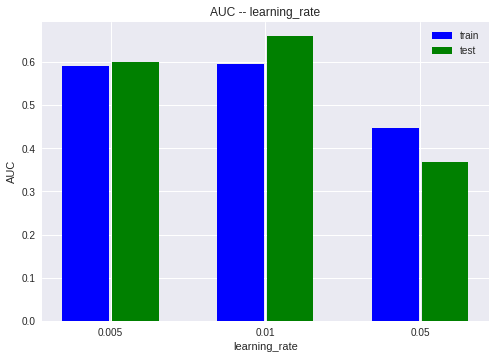

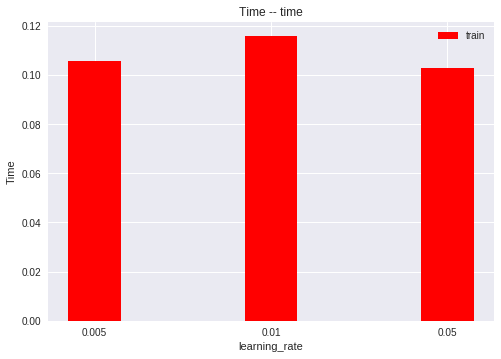

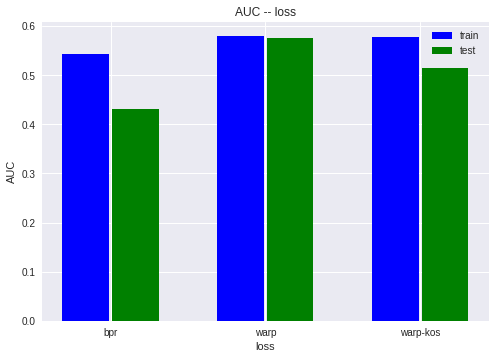

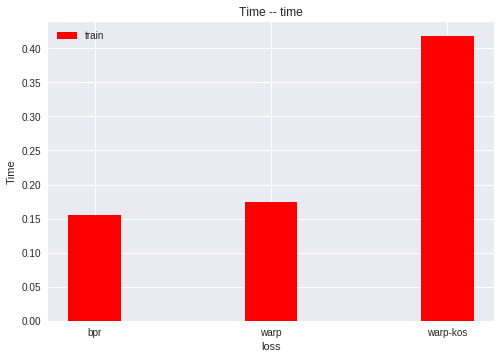

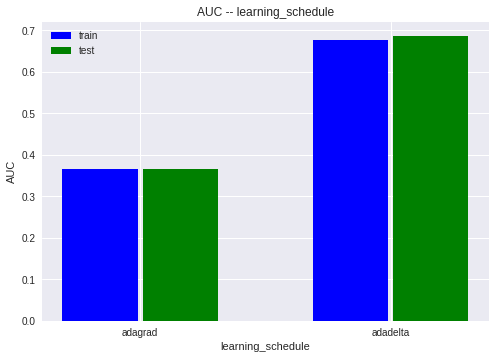

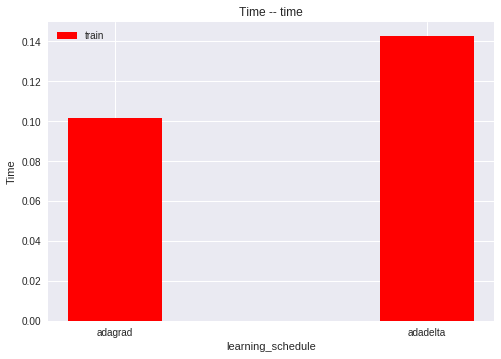

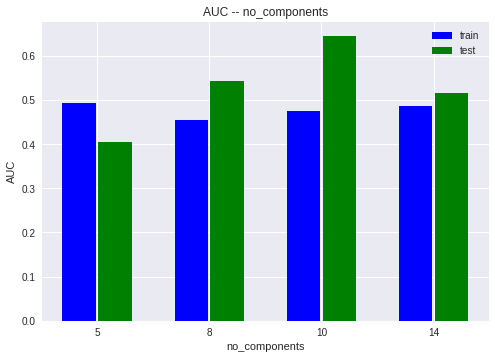

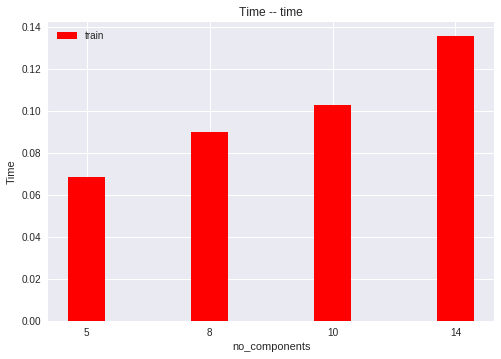

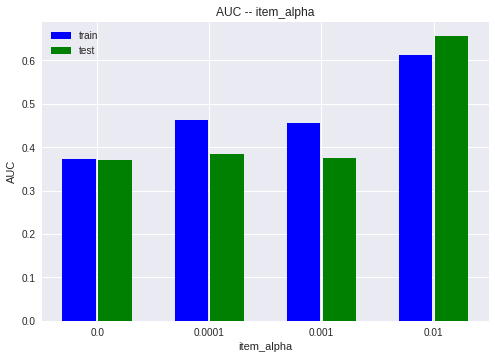

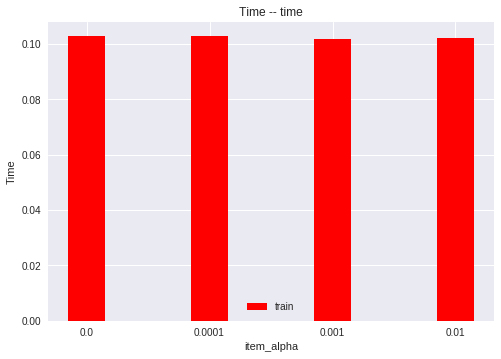

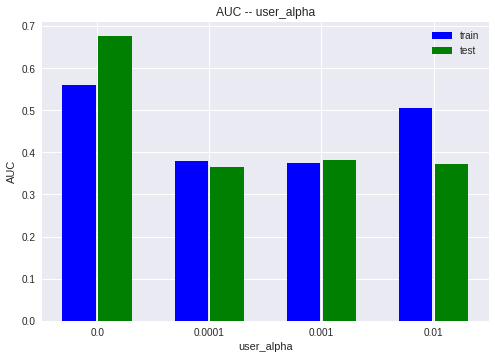

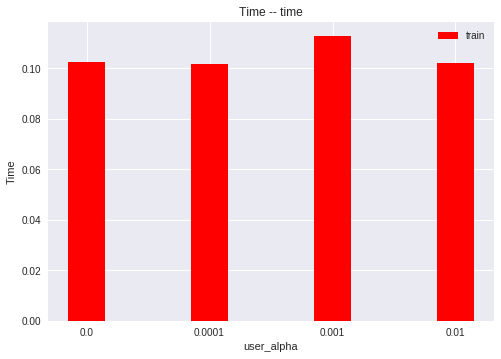

In [72]:
def plotGridSearchResults(gridSearchResults):
  for param, paramResults in gridSearchResults.items():
    gridSearchDF = pd.DataFrame(paramResults)
   
    barWidth = 0.3
    barSpace = 0.16
    _X = np.arange(len(gridSearchDF['value']))
    plt.bar(_X - barSpace, gridSearchDF['train_auc'], barWidth, color='blue')
    plt.bar(_X + barSpace, gridSearchDF['test_auc'], barWidth, color='green')
    plt.xticks(_X, gridSearchDF['value'])
    plt.title('AUC -- {}'.format(param))
    plt.ylabel('AUC')
    plt.xlabel(param)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    plt.bar(_X, gridSearchDF['time'], barWidth, color='red')
    plt.xticks(_X, gridSearchDF['value'])
    plt.title('Time -- {}'.format('time'))
    plt.ylabel('Time')
    plt.xlabel(param)
    plt.legend(['train'], loc='best')
    plt.show()
  
plotGridSearchResults(gridSearchResults)

## Find Best Number of Epochs

In [0]:
def runModelOverEpochs(params, XTrain, XTest, maxEpochs): 
  model = LightFM(**params)
  results = []
  
  runningTotalTime = 0
  for epoch in range(1, maxEpochs + 1):
    startTime = time()
    model.fit_partial(XTrain, item_features = side_info_matrix)
    totalTime = time() - startTime
    runningTotalTime += totalTime
    train_auc = auc_score(model, XTrain, item_features = side_info_matrix).mean()
    test_auc = auc_score(model, XTest, item_features = side_info_matrix).mean()
    results.append((train_auc, test_auc, runningTotalTime, epoch))
  return results

In [0]:
def epochSearch(XTrain, XValidate, maxEpochs):
  
  modelResults = runModelOverEpochs(bestParams, XTrain, XValidate, maxEpochs)
  
  epochSearchResults = []
  for train_auc, test_auc, time, epoch in modelResults:
    epochSearchResults.append({
        'train_auc': train_auc,
        'test_auc': test_auc,
        'epoch': epoch,
        'time': time,
    })
    
#   print(epochSearchResults)
  return epochSearchResults

In [81]:
startTime = time()

maxEpochs = 20
epochSearchResults = []
for XTrain, XValidate in XTrainValidateFolds:
  epochSearchResults.append(epochSearch(XTrain, XValidate, maxEpochs))
#   downloadCSVFile(epochSearchResults, 'epochSearchResults.csv')

totalTime = time() - startTime
if totalTime > 60:
    print('Total time: {:0.2f} minutes'.format(totalTime / 60))
else:
    print('Total time: {:0.2f} seconds'.format(totalTime))

Total time: 2.03 minutes


In [82]:
def findBestEpoch(epochSearchResults):
  previousAUC = -10
  bestEpoch = -1
  
  for result in epochSearchResults:
    testAUC = result['test_auc']
    if testAUC > previousAUC:
      previousAUC = testAUC
      bestEpoch = result['epoch']
  return bestEpoch
      
    
bestEpochs = []
for index, epochSearchResult in enumerate(epochSearchResults):
  bestEpochFold = findBestEpoch(epochSearchResult)
  bestEpochs.append(bestEpochFold)
  print('The best number of Epochs for fold {} is {}'.format(index + 1, bestEpochFold))

bestEpoch = int(np.median(bestEpochs))
print('')
print('The best number of Epochs overall is {}'.format(bestEpoch))

The best number of Epochs for fold 1 is 7
The best number of Epochs for fold 2 is 3
The best number of Epochs for fold 3 is 3

The best number of Epochs overall is 3


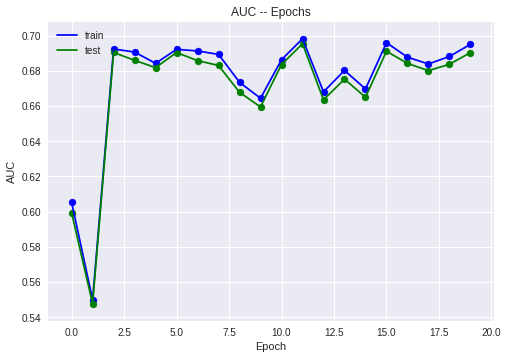

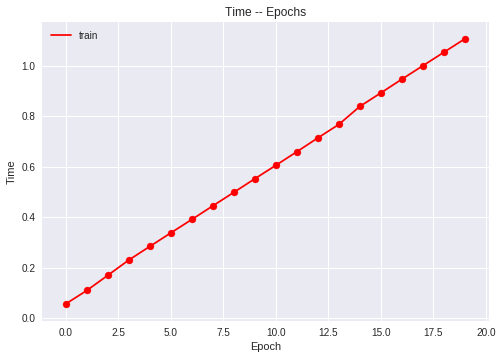

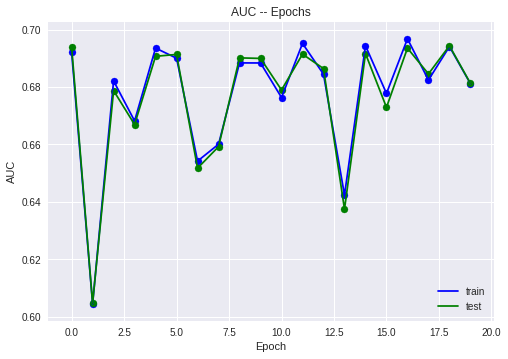

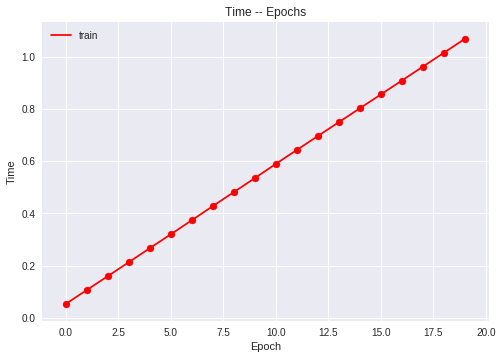

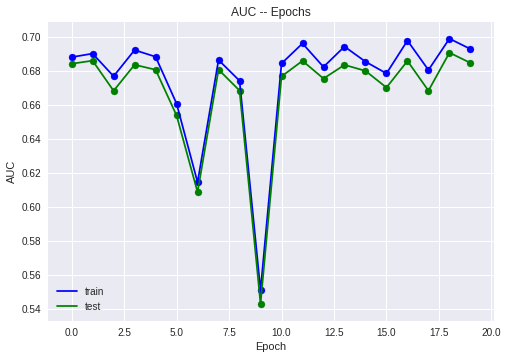

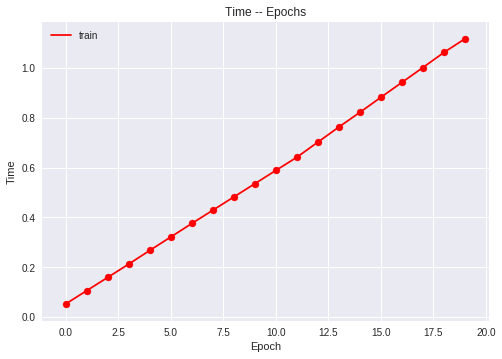

In [77]:
def plotEpochSearchResults(epochSearchResults):
  for epochSearchResult in epochSearchResults:
    epochSearchDF = pd.DataFrame(epochSearchResult)
    plt.plot(epochSearchDF['epoch'], epochSearchDF['train_auc'], color='blue')
    plt.scatter(epochSearchDF['epoch'], epochSearchDF['train_auc'], color='blue')
    plt.plot(epochSearchDF['epoch'], epochSearchDF['test_auc'], color='green')
    plt.scatter(epochSearchDF['epoch'], epochSearchDF['test_auc'], color='green')
    plt.title('AUC -- Epochs')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    plt.plot(epochSearchDF['epoch'], epochSearchDF['time'], color='red')
    plt.scatter(epochSearchDF['epoch'], epochSearchDF['time'], color='red')
    plt.title('Time -- Epochs')
    plt.ylabel('Time')
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='best')
    plt.show()

  
plotEpochSearchResults(epochSearchResults)

# Sampling Amount of Data

In [83]:
dataFractions = np.arange(0.2, 1.2, 0.2)
numRatings = len(ratingsTrainDF)
dataSizes = [int(fraction * numRatings) for fraction in dataFractions]
dataSizes

[16133, 32267, 48400, 64534, 80668]

In [0]:
def sizeSamplingSearch(dataSizes):
  sizeSamplingResults = []

  for numRatings in dataSizes:
    print('Running for size: {}'.format(numRatings))
    ratingsTrainDFSampled = ratingsTrainDF.sample(n=numRatings)
    XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndex)
    train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest, bestEpoch)
    result = {
        'numRatings': numRatings,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'time': totalTime,
    }
    sizeSamplingResults.append(result)

  return sizeSamplingResults

In [85]:
sizeSamplingResults = sizeSamplingSearch(dataSizes)


Running for size: 16133
Running for size: 32267
Running for size: 48400
Running for size: 64534
Running for size: 80668


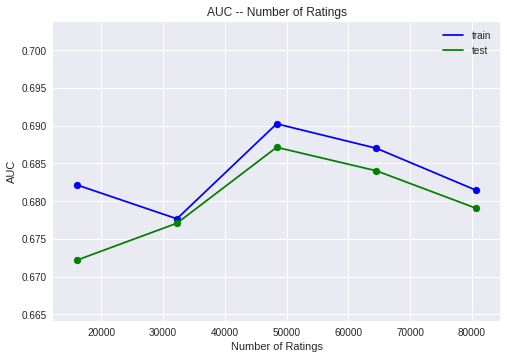

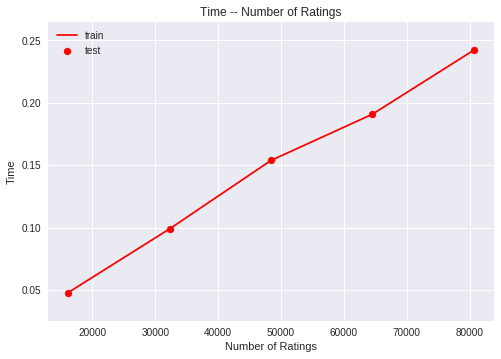

In [86]:
def plotSizeSamplingResults(sizeSamplingResults):
  sizeSamplingDF = pd.DataFrame(sizeSamplingResults)
  
  plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['train_auc'], color='blue')
  plt.plot(sizeSamplingDF['numRatings'], sizeSamplingDF['train_auc'], color='blue')
  plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['test_auc'], color='green')
  plt.plot(sizeSamplingDF['numRatings'], sizeSamplingDF['test_auc'], color='green')
  plt.title('AUC -- Number of Ratings')
  plt.ylabel('AUC')
  plt.xlabel('Number of Ratings')
  plt.legend(['train', 'test'], loc='best')
  plt.show()
  
  plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['time'], color='red')
  plt.plot(sizeSamplingDF['numRatings'], sizeSamplingDF['time'], color='red')
  plt.title('Time -- Number of Ratings')
  plt.ylabel('Time')
  plt.xlabel('Number of Ratings')
  plt.legend(['train', 'test'], loc='best')
  plt.show()
  
  
plotSizeSamplingResults(sizeSamplingResults)

# Sample By Number of Users

In [0]:
def sortUsersByDensity(ratingsDF):
  counts = ratingsDF['userId'].value_counts()
  return np.asarray(counts.keys())

In [27]:
numUsersTotal = len(userIds)
userIdsByDensity = sortUsersByDensity(ratingsDF)
userFractions = np.arange(0.2, 1.2, 0.2)
userSizes = [int(fraction * numUsersTotal) for fraction in userFractions]
userSizes

[122, 244, 366, 488, 610]

In [0]:
def userSamplingSearch(userSizes):
  userSamplingResultsDense = []

  for numUsers in userSizes:
    print('Running for the most dense users of size: {}'.format(numUsers))
    sampledUserIds = userIdsByDensity[:numUsers]
    userIdToIndexSampled = {}
    for index, userId in enumerate(sampledUserIds):
      userIdToIndexSampled[userId] = index
      
    ratingsTrainDFSampled = ratingsTrainDF[ratingsTrainDF['userId'].isin(sampledUserIds)]
    ratingsTestDFSampled = ratingsTestDF[ratingsTestDF['userId'].isin(sampledUserIds)]
    
    XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndexSampled, movieIdToIndex)
    XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndexSampled, movieIdToIndex)
    
    train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest, bestEpoch)
    result = {
        'numUsers': numUsers,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'time': totalTime,
    }
    userSamplingResultsDense.append(result)
    
    
  userSamplingResultsSparse = []
  
  for numUsers in userSizes:
    print('Running for the least dense users of size: {}'.format(numUsers))
    sampledUserIds = userIdsByDensity[(numUsersTotal - numUsers):]
    userIdToIndexSampled = {}
    for index, userId in enumerate(sampledUserIds):
      userIdToIndexSampled[userId] = index
      
    ratingsTrainDFSampled = ratingsTrainDF[ratingsTrainDF['userId'].isin(sampledUserIds)]
    ratingsTestDFSampled = ratingsTestDF[ratingsTestDF['userId'].isin(sampledUserIds)]

    
    XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndexSampled, movieIdToIndex)
    XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndexSampled, movieIdToIndex)
    
    train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest, bestEpoch)
    result = {
        'numUsers': numUsers,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'time': totalTime,
    }
    userSamplingResultsSparse.append(result)

  return userSamplingResultsDense, userSamplingResultsSparse

In [29]:
userSamplingResultsDense, userSamplingResultsSparse = userSamplingSearch(userSizes)
# userSamplingResults

Running for the most dense users of size: 122
Running for the most dense users of size: 244
Running for the most dense users of size: 366
Running for the most dense users of size: 488
Running for the most dense users of size: 610
Running for the least dense users of size: 122
Running for the least dense users of size: 244
Running for the least dense users of size: 366
Running for the least dense users of size: 488
Running for the least dense users of size: 610


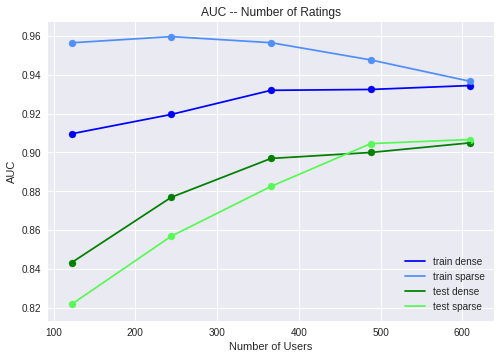

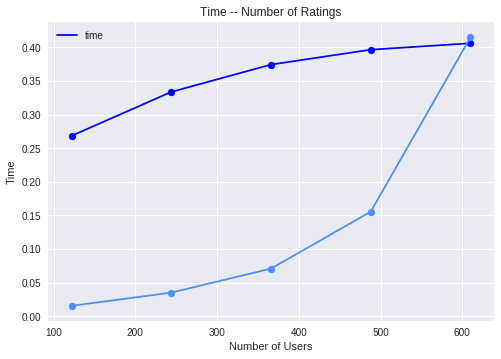

In [30]:
def plotUserSamplingResults(userSamplingResultsDense, userSamplingResultsSparse):
  sizeSamplingDFDense = pd.DataFrame(userSamplingResultsDense)
  sizeSamplingDFSparse = pd.DataFrame(userSamplingResultsSparse)
  
  plt.scatter(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['train_auc'], color='blue')
  plt.scatter(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['train_auc'], color='#4f8ff7')
  plt.scatter(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['test_auc'], color='green')
  plt.scatter(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['test_auc'], color='#57f954')
  plt.plot(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['train_auc'], color='blue')
  plt.plot(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['train_auc'], color='#4f8ff7')
  plt.plot(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['test_auc'], color='green')
  plt.plot(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['test_auc'], color='#57f954')
  plt.title('AUC -- Number of Ratings')
  plt.ylabel('AUC')
  plt.xlabel('Number of Users')
  plt.legend(['train dense', 'train sparse', 'test dense', 'test sparse'], loc='best')
  plt.show()
  
  plt.scatter(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['time'], color='blue')
  plt.scatter(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['time'], color='#4f8ff7')
  plt.plot(sizeSamplingDFDense['numUsers'], sizeSamplingDFDense['time'], color='blue')
  plt.plot(sizeSamplingDFSparse['numUsers'], sizeSamplingDFSparse['time'], color='#4f8ff7')
  plt.title('Time -- Number of Ratings')
  plt.ylabel('Time')
  plt.xlabel('Number of Users')
  plt.legend( ['time'], loc='best')
  plt.show()
 
  
plotUserSamplingResults(userSamplingResultsDense, userSamplingResultsSparse)

# Sample By Number Of Movies

In [0]:
def sortMoviesByDensity(ratingsDF):
  counts = ratingsDF['movieId'].value_counts()
  return np.asarray(counts.keys())

In [32]:
numMoviesTotal = len(movieIds)
movieIdsByDensity = sortMoviesByDensity(ratingsDF)
movieFractions = np.arange(0.2, 1.2, 0.2)
movieSizes = [int(fraction * numMoviesTotal) for fraction in movieFractions]
movieSizes

[1944, 3889, 5834, 7779, 9724]

In [0]:
def movieSamplingSearch(movieSizes):
  movieSamplingResultsDense = []

  for numMovies in movieSizes:
    print('Running for the most dense movies of size: {}'.format(numMovies))
    sampledMovieIds = movieIdsByDensity[:numMovies]
    movieIdToIndexSampled = {}
    for index, movieId in enumerate(sampledMovieIds):
      movieIdToIndexSampled[movieId] = index
      
    ratingsTrainDFSampled = ratingsTrainDF[ratingsTrainDF['movieId'].isin(sampledMovieIds)]
    ratingsTestDFSampled = ratingsTestDF[ratingsTestDF['movieId'].isin(sampledMovieIds)]
    
    XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndexSampled)
    XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndex, movieIdToIndexSampled)
    
    train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest, bestEpoch)
    result = {
        'numMovies': numMovies,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'time': totalTime,
    }
    movieSamplingResultsDense.append(result)
    
    
  movieSamplingResultsSparse = []
  
  for numMovies in movieSizes:
    print('Running for the least dense movies of size: {}'.format(numMovies))
    sampledMovieIds = movieIdsByDensity[(numMoviesTotal - numMovies):]
    movieIdToIndexSampled = {}
    for index, movieId in enumerate(sampledMovieIds):
      movieIdToIndexSampled[movieId] = index
      
    ratingsTrainDFSampled = ratingsTrainDF[ratingsTrainDF['movieId'].isin(sampledMovieIds)]
    ratingsTestDFSampled = ratingsTestDF[ratingsTestDF['movieId'].isin(sampledMovieIds)]

    
    XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndexSampled)
    XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndex, movieIdToIndexSampled)
    
    train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest, bestEpoch)
    result = {
        'numMovies': numMovies,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'time': totalTime,
    }
    movieSamplingResultsSparse.append(result)

  return movieSamplingResultsDense, movieSamplingResultsSparse

In [34]:
movieSamplingResultsDense, movieSamplingResultsSparse = movieSamplingSearch(movieSizes)
# userSamplingResults

Running for the most dense movies of size: 1944
Running for the most dense movies of size: 3889
Running for the most dense movies of size: 5834
Running for the most dense movies of size: 7779
Running for the most dense movies of size: 9724
Running for the least dense movies of size: 1944
Running for the least dense movies of size: 3889
Running for the least dense movies of size: 5834
Running for the least dense movies of size: 7779
Running for the least dense movies of size: 9724


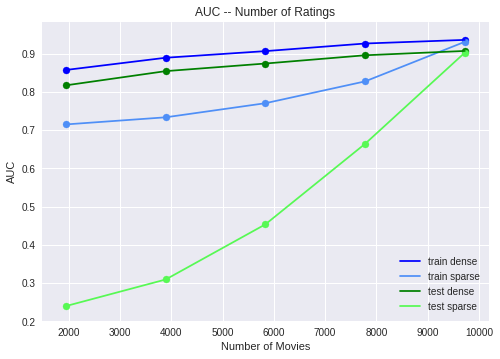

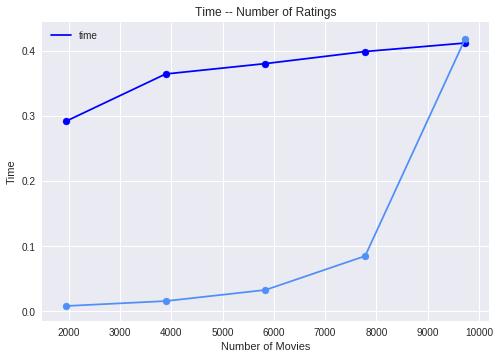

In [35]:
def plotMovieSamplingResults(movieSamplingResultsDense, movieSamplingResultsSparse):
  sizeSamplingDFDense = pd.DataFrame(movieSamplingResultsDense)
  sizeSamplingDFSparse = pd.DataFrame(movieSamplingResultsSparse)
  
  plt.scatter(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['train_auc'], color='blue')
  plt.scatter(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['train_auc'], color='#4f8ff7')
  plt.scatter(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['test_auc'], color='green')
  plt.scatter(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['test_auc'], color='#57f954')
  plt.plot(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['train_auc'], color='blue')
  plt.plot(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['train_auc'], color='#4f8ff7')
  plt.plot(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['test_auc'], color='green')
  plt.plot(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['test_auc'], color='#57f954')
  plt.title('AUC -- Number of Ratings')
  plt.ylabel('AUC')
  plt.xlabel('Number of Movies')
  plt.legend(['train dense', 'train sparse', 'test dense', 'test sparse'], loc='best')
  plt.show()
  
  plt.scatter(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['time'], color='blue')
  plt.scatter(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['time'], color='#4f8ff7')
  plt.plot(sizeSamplingDFDense['numMovies'], sizeSamplingDFDense['time'], color='blue')
  plt.plot(sizeSamplingDFSparse['numMovies'], sizeSamplingDFSparse['time'], color='#4f8ff7')
  plt.title('Time -- Number of Ratings')
  plt.ylabel('Time')
  plt.xlabel('Number of Movies')
  plt.legend( ['time'], loc='best')
  plt.show()
  
plotMovieSamplingResults(movieSamplingResultsDense, movieSamplingResultsSparse)